<div style="text-align: center;"><br>
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

# H-Series Emulators

An emulator can be used to get an idea of what a quantum device will output for a given quantum circuit. This enables circuit debugging and optimization before running on a physical machine. Emulators differ from simulators in that they model the physical and noise model of the device whereas simulators may model noise parameters, but not physical parameters. 

The Quantinuum emulators run on a physical noise model of the Quantinuum H-Series devices. There are various noise/error parameters modeled. For detailed information on the noise model, see the emulator data sheets on the [System Model H1](#https://www.quantinuum.com/products/h1) or [System Model H2](#https://www.quantinuum.com/products/h2) pages.

* **State vector Emulator**: The default mode of all emulators. The emulator will compute the state vector of the circuit and estimate the measurement distribution from that state vector. (option: `state-vector`)
* **Stabilizer Emulator:** Use of the emulator for circuits involving only Clifford operations. This is only available on cloud emulators (option: `stabilizer`)
* **Nexus-hosted Emulators:** 20-qubit instances of H-Series emulators are hosted in Nexus. The `H1-Emulator` and `H2-Emulator` targets enable `state-vector` and `stabilizer` emulation whilst including the physical noise model of the Quantinuum device. Emulator targets ending with `LE` enable noiseless (`state-vector`) emulation, which means that only shot-noise is included in the job result.
* **Noise Model Customization:** Experiment with the noise parameters in the emulator. There is no guarantee that results achieved by changing these parameters will represent outputs from the actual quantum computer represented. This is not available for emulator targets ending in `LE`.

<div style="text-align: center;">
    <img src="figures/emulator_fig1.png" width="800">
</div>

**Contents**

* [Emulator Availability and Usage](#Emulator-Availability-and-Usage)
* [Basic Usage](#Basic-Usage)
* [State vector and Stabilizer Emulation](#State-vector-and-Stabilizer-Emulation)
* [Noiseless Emulation](#Noiseless-Emulation)
* [Noise Model Customization](#Noise-Model-Customization)
* [Use Case: Noise Model Analysis](#Use-Case:-Noise-Model-Analysis)

## Emulator Availability and Usage

All H-Series devices have <font color="#688195">noisy emulators</font> (suffix `E` or `Emulator`) and <font color="#883A5E">noiseless emulators</font> (suffix `LE`). The Emulator targets with suffix `Emulator` or `LE` are hosted on nexus, but with the total number of qubits capped at 20-qubits.

Users can access <font color="#688195">noisy emulators</font> with their Quantinuum credentials over the cloud via the Fair Queue. These emulators are hosted in the H-Series stack, consume HQCs upon usage, are available 24/7, and replicate H-Series device and noise characteristics unless the user utilizes the noise model options.

User can also access <font color="#883A5E">nexus-hosted emulators</font> without submitting to a Fair Queue or consuming HQCs. The emulators with suffix `LE` only provide noiseless `state-vector` emulation modeling physical characteristics like transport, but not noise. The user submits to a first-in first-out queue, operated within Nexus.

For smaller noiseless emulations involving less than 16 qubits, it is recommended to use the <font color="#883A5E">nexus-hosted emulators</font>. For larger emulations, or emulations using a noise model, <font color="#688195">cloud emulators</font> is recommended.

All emulators provide the following features:
* Usage of arbitrary-angle two-qubit gates as well as other native H-Series gates
* All-to-all connectivity
* Mid-circuit measurements and reset (MCMR) and qubit reuse
* Identical number of qubits to the corresponding device (see emulator datasheets). Nexus-hosted emulators are capped at 20-qubits.

Noisy Emulators provide the following capabilites:
* A noise model replicating device noise characteristics
* `state-vector` and `stabilizer` simulators. `State-vector` simulators have up to 32 qubits. `Stabilizer` simulator has up to 56 qubits.

Emulators hosted in the H-Series stack provide the following features:
* Job Batching (run all jobs by a user in succession)


H-Series-hosted Emulators can only be accessed via the Fair Queue. Queue time is dependent on HQC accumulation and user- and group-priorities within their organization. Emulator run-time is dependent on the number of qubits and number of operations in the job. Noisy emulations are slower than noiseless emulations.

Jobs submitted to the H-Series-hosted emulator with a high shot count are automatically *chunked* into multiple partitions with fewer shots. This enables an incremental distribution of emulator resources.

<div style="text-align: center;">
    <img src="figures/emulator_fig2.png" width=800 />
</div>

## Basic Usage

In the cell below, a `qnexus` project is retrived from the nexus database and set as the active-project throughout the lifetime of the python session. A backend configuration uses `device_name` argument to target a nexus-hosted emulator (`H1-Emulator`). The `qnexus` is used to perform the following workflow:

* **Compile** job to transform the quantum program to satisfy the gate set predicate for the emulator using the instance `qnexus.start_compile_job` method.
* **Execute** job to submit the circuit for emulation via `qnexus.start_execute_job`.
* **Check job status** for the submitted circuit with `qnexus.jobs.status` method.
* **Retrieve** job result after emulation with `download_result` method on the `qnexus` result reference.

This workflow is identical for both Quantum Processing Unit (QPU) usage and emulator usage.

**This workflow is the default (and simplest) for the H-Series emulators. In most cases, we recommend users use this workflow since it will mimic device performance.**

In [1]:
import qnexus

project = qnexus.projects.get_or_create(name="Emulator-Demonstration")
qnexus.context.set_active_project(project)

In [2]:
config = qnexus.QuantinuumConfig(device_name="H1-Emulator")

In [3]:
config = qnexus.QuantinuumConfig(device_name="H1-1LE")

In [4]:
import datetime

job_name_suffix = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
job_name_suffix

'2024_08_09-11_35_54'

The 4-qubit circuit below contains the following features:

* Native arbitrary-angle two-qubit gate (`OpType.ZZPhase`)
* Native arbitrary-angle one-qubit gate (`OpType.PhasedX`)
* MCMR (mid-circuit measurement with reset)
* Classically-controlled `OpType.X` operation

In [5]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

circuit = Circuit(4, 1)
for i, j in zip(circuit.qubits[:-1], circuit.qubits[1:]):
    circuit.ZZPhase(0.1, i, j)

# Add MCMR
circuit.Measure(circuit.qubits[-1], circuit.bits[0])
circuit.Reset(circuit.qubits[-1])
circuit.X(circuit.qubits[-1], condition=circuit.bits[0])

for i, j in zip(circuit.qubits[:-1], circuit.qubits[1:]):
    circuit.ZZPhase(0.1, i, j)
for i in circuit.qubits:
    circuit.PhasedX(0.06, -0.09, i)

## Add Final Measurement
circuit.measure_all()

render_circuit_jupyter(circuit)

In [6]:
ref_circuit = qnexus.circuits.upload(circuit=circuit, name="circuit-1")

Compiling the circuit, replaces the classically-controlled `OpType.X` operation with an `OpType.Phase` node and a classically-controlled `Optype.PhasedX`.

In [7]:
ref_compile_job = qnexus.start_compile_job(
    circuits=[ref_circuit],
    name=f"compile-simple-circuit-{job_name_suffix}",
    backend_config=config,
    optimisation_level=2
)

In [8]:
qnexus.jobs.wait_for(ref_compile_job)
job_result = qnexus.jobs.results(ref_compile_job)[0]
compilation_result_ref = job_result.get_output()

In [9]:
compiled_circuit = compilation_result_ref.download_circuit()

In [10]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(compiled_circuit)

`qnexus.start_execute_job` is used to submit the compiled circuit for emulation to the nexus-hosted emulator.

In [11]:
execution_ref = qnexus.start_execute_job(
    circuits=[compilation_result_ref], # <- Don't have to download, can just use the reference.
    name=f"execution-simple-circuit-{job_name_suffix}",
    backend_config=config,
    n_shots=[100],
)

In [12]:
qnexus.jobs.wait_for(execution_ref)
qnexus.jobs.status(execution_ref)

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 8, 9, 10, 38, 18, 87423, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 8, 9, 10, 36, 13, 725532, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 8, 9, 10, 38, 12, 813793, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)

In [13]:
result = qnexus.jobs.results(execution_ref)[0].download_result()

In [14]:
result.get_distribution()

{(0, 0, 0, 0): 0.98, (0, 1, 0, 0): 0.02}

## State vector and Stabilizer Emulator

The following options can only be used when using the cloud H-Series emulators (ending with **E** and not **LE**).

There are two types of simulation methods, `state-vector` and `stabilizer`. These can be specified during construction of `qnexus.QuantinuumConfig` via the `simulator` keyword argument. The default value is `state-vector`.

<div style="text-align: center;">
    <img src="figures/emulator_fig3.png" width="1200">
</div>

If the quantum operations are all Clifford gates, it is faster to use the `stabilizer` emulator. The `stabilizer` emulator is requested in the setup of the `qnexus.QuantinuumConfig` with the `simulator` input option. This option can only be used with noisy H-Series emulators.

In [15]:
machine = "H1-Emulator"
stabilizer_config = qnexus.QuantinuumConfig(device_name=machine, simulator="stabilizer")

In [16]:
circuit2 = Circuit(2).CX(0, 1)

In [17]:
ref2 = qnexus.circuits.upload(circuit2, name="circuit2")

In [18]:
ref_compile2 = qnexus.start_compile_job(
    circuits=[ref2],
    name=f"compile-simple-circuit-2-{job_name_suffix}",
    backend_config=config,
    optimisation_level=2
)

In [19]:
qnexus.jobs.wait_for(ref_compile_job)
compiled_circuit = job_result.get_output().download_circuit()

In [20]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(compiled_circuit)

## Noiseless Emulation

### Enabling and Disabling the Error Model with the Cloud Emulators

Quantinuum emulators may be run with or without the physical device's noise model. The default is the emulator runs with the physical noise model turned on. The physical noise model can be turned off by setting `noisy_simulation=False`. Noiseless simulation can be used with both `state-vector` and `stabilizer` emulator.

In [21]:
import qnexus

config_noiseless_1 = qnexus.QuantinuumConfig(device_name="H1-Emulator", noisy_simulation=False)

### Noiseless Emulation using H-Series with LE suffix

There are emulator targets with the **LE** suffix hosted in nexus. Each target corresponds to a H-Series device.

In [22]:
config_le_emulator = qnexus.QuantinuumConfig(device_name="H1-1LE")

## Noise Model Customization

The emulator runs with default error parameters that represent a noise environment similar to the physical devices. For detailed information on the noise model, see the product data sheet for the device you want to emulate on the [System Model H1](#https://www.quantinuum.com/products/h1) or [System Model H2](#https://www.quantinuum.com/products/h2) page. 

The `UserErrorParams` object can be used to customize the noise model. This can be supplied to the `QuantinuumConfig` constructor with a keyword argument `error_params`. 

In this section, examples are given for experimenting with the noise and error parameters of the emulators. These are advanced options and not recommended to start with when doing initial experiments. As mentioned above, there is no guarantee that results achieved changing these parameters will represent outputs from the actual quantum computer represented.

**Note:** All the noise parameters are used together any time a simulation is run. If only some of the parameters are specified, the rest of the parameters are used at their default settings. The parameters to override are specified with the options parameter.

The example below specifies the options with the `QuantinuumConfig` constructor.

In [23]:
import qnexus
from qnexus.models.h_series_noise import UserErrorParams

user_error_params = UserErrorParams(
    quadratic_dephasing_rate=0.1
)

config = qnexus.QuantinuumConfig(device_name="H1-Emulator", error_params=user_error_params)

### Physical Noise

See the product data sheet for the device you want to emulate for information on these parameters.

In [24]:
user_error_params = UserErrorParams(
    p1=4e-5,
    p2=3e-3,
    p_meas=3e-3,
    p_init=4e-5,
    p_crosstalk_meas=1e-5,
    p_crosstalk_init=3e-5,
    p1_emission_ratio=0.15,
    p2_emission_ratio=0.3
)

config = qnexus.QuantinuumConfig(device_name="H1-Emulator", error_params=user_error_params)

### Dephasing Noise

The noise model includes a memory error for which Pauli-$Z$ is applied. This is often called "dephasing" or "memory" noise. There are two relationships between the probability of dephasing error and the duration for which qubits are idling or transporting in the trap:

1. the probability is quadratically dependent on the duration
2. the probability is linearly dependent on the duration

For both the `state-vector` and `stabilizer` simulations, linear dephasing is also modeled with Pauli-$Z$ applied with a probability equal to rate, $r$, multiplied by duration, $d$.

For `state-vector` simulations, the quadratic noise is modeled in the emulator by default as coherent noise. For this coherent quadratic dephasing noise, the $Rz$ gate is applied with an angle proportional to frequency, $f$, multiplied by duration, $d$. The probability of the $Rz$ gate applying a Pauli-$Z$ operation on a plus state, $| + \rangle$, is $\sin( fd/2 )^2$, which is why we call this a form of quadratic dephasing.

For the `stabilizer` simulator, by default this quadratic noise is modeled incoherent by applying Pauli-$Z$ with probability $\sin{(fd)}^2$ to model more closely the quadratic dependency with frequency and time as seen in the coherent model. Note, `stabilizer` simulations can only simulate Clifford and measurement-like gates, so the $Rz$ gate cannot be applied directly. 

See the product data sheet for the device you want to emulate for information on these parameters.

In [25]:
user_error_params = UserErrorParams(
    quadratic_dephasing_rate=0.2,
    linear_dephasing_rate=0.3,
    coherent_to_incoherent_factor=2.0,
    coherent_dephasing=False,
    transport_dephasing=False,
    idle_dephasing=False
)

config = qnexus.QuantinuumConfig(device_name="H1-Emulator", error_params=user_error_params)

### Arbitrary Angle Noise Scaling

The System Model H1 systems have a native arbitrary-angle $ZZ$ gate, $RZZ(\theta)$. For implementation of this gate in the System Model H1 emulator, 
certain parameters relate to the strength of the asymmetric depolarizing noise. These parameters depend on the angle $\theta$. This is normalized so 
that $\theta=\pi/2$ gives the two-qubit fault probability (`p2`). The parameters for asymmetric depolarizing noise are fit parameters that fit the 
noise estimated as the angle, $\theta$, changes per this equation:

The parameters for asymmetric depolarizing noise are fit parameters that fit the noise estimated as the angle, $\theta$, changes per this equation:

\begin{align}
(przz_a (|\theta|/\pi)^{przz_{power}} + przz_b) p2; \quad &\theta &< 0 \\

(przz_c (|\theta|/\pi)^{przz_{power}} + przz_d) p2; \quad &\theta &> 0 \\

0.5 (przz_b + przz_d); \quad &\theta &= 0
\end{align}

See the product data sheet for the device you want to emulate for information on these parameters.

In [26]:
user_error_params = UserErrorParams(
    przz_a=1.09,
    przz_b=0.035,
    przz_c=1.09,
    przz_d=0.035,
    przz_power=0.5
)

config = qnexus.QuantinuumConfig(device_name="H1-Emulator", error_params=user_error_params)

### Scaling Factors

A scaling factor can be applied that multiplies all the default or supplied error parameters by the scaling rate. In this case, 1 does not change the error rates while 0 makes all the errors have a probability of 0.

All the error rates can be scaled linearly using the **scale** parameter.

In [27]:
user_error_params = UserErrorParams(
    scale=0.1
)

config = qnexus.QuantinuumConfig(device_name="H1-Emulator", error_params=user_error_params)

See the product data sheet for the device you want to emulate for information on these parameters.

In [28]:
user_error_params = UserErrorParams(
    p1_scale=0.1,
    p2_scale=0.1,
    meas_scale=0.1,
    init_scale=0.1,
    memory_scale=0.1,
    emission_scale=0.1,
    crosstalk_scale=0.1,
    leakage_scale=0.1
)

config = qnexus.QuantinuumConfig(device_name="H1-Emulator", error_params=user_error_params)

## Use Case: Noise Model Analysis

The noise model can be configured on the `state-vector` simulator in order to assess performance improvements for a particular use case as certain hardware noise parameters (i.e. the two-qubit gate fidelity improves).

This use case looks at the Jensen-Shannon divergence (JSD) as the `p2` noise model value is modified. JSD is a measure of result quality, `0` is the maximal quality and `1` is the worst. A random circuit is submitted to the emulator for 5 different values of `p2`. The JSD can be computed once results are available from the noisy emulation. Emulation results are compared to results from an ideal case, and this is a benchmark for similarity between the two measurement distributions.

The code cell below generates 5 `p2` values between 0 and 0.1.

In [29]:
import numpy as np

p2_list = np.linspace(0, 0.1, num=5, endpoint=True)

The code below generates a 10-qubit circuit with 10 repeating sub-blocks. Each sub-block contains `OpType.PhasedX` and `OpType.ZZPhase` operations.

In [30]:
from pytket.circuit import Circuit

circuit = Circuit(10)

for i in range(10):
    for j, qubit in enumerate(circuit.qubits):
        a0 = j * 0.05**i
        a1 = j * 0.1**i
        circuit.PhasedX(a0, a1, qubit)

    for j, (q0, q1) in enumerate(zip(circuit.qubits[:-1], circuit.qubits[1:])):
        angle = 0.1**i
        circuit.ZZPhase(0.1, q0, q1)

circuit.measure_all();

In [31]:
ref_nma = qnexus.circuits.upload(circuit, name="nma-circuit")

The local (noiseless) emulator, `H1-1LE`, is used to obtain a distribution of measurement outcomes in the ideal case.

In [32]:
noiseless_config = qnexus.QuantinuumConfig(device_name="H1-1LE")

In [33]:
ref_compile_job_nma = qnexus.start_compile_job(
    name=f"nma-compilation-job-{job_name_suffix}",
    circuits=[ref_nma],
    backend_config=noiseless_config,
    optimisation_level=2
)

In [34]:
qnexus.jobs.wait_for(ref_compile_job_nma)
ref_compile_circuit_nma = qnexus.jobs.results(ref_compile_job_nma)[0].get_output()

In [35]:
ref_execute_job_nma = qnexus.start_execute_job(
    name=f"nma-execution-job-{job_name_suffix}",
    circuits=[ref_compile_circuit_nma],
    backend_config=noiseless_config,
    n_shots=[100]
)

In [36]:
qnexus.jobs.wait_for(ref_execute_job_nma)
result_ideal = qnexus.jobs.results(ref_execute_job_nma)[0].download_result()

The cloud emulator, `H1-Emulator`, will be used with the noise model enabled to emulate the circuit defined above. The noise model will be customized by supplying a different `p2` value as a Quantinuum API option upon job submission.

In [37]:
execution_job_ref_list = []
for i, p2 in enumerate(p2_list):
    config = qnexus.QuantinuumConfig(device_name="H1-Emulator", error_params=UserErrorParams(p2=p2))
    ref = qnexus.start_execute_job(
        name=f"nma-execution-job-noisy-{job_name_suffix}-{i}",
        circuits=[ref_compile_circuit_nma],
        backend_config=config,
        n_shots=[100]
    )
    execution_job_ref_list += [ref]

In [39]:
qnexus.jobs.wait_for(ref)
results_noisy = [qnexus.jobs.results(ref)[0].download_result() for ref in execution_job_ref_list]

Below, methods are defined to enable computation of the JSD.

1. Probabilities are collated and ordered by bitstring for each measurement distribution.
2. The JSD is computed for each measurement distribution from the noisy emulator against the ideal measurement distribution.

In [40]:
import itertools

from numpy import asarray
from numpy.linalg import norm

from scipy.stats import entropy

from pytket.backends.backendresult import BackendResult


def bitstring_ordering(n_bits):
    for x in itertools.product("01", repeat=n_bits):
        yield "".join(x)


def collect_probabilities(
    result: BackendResult,
):
    distribution = {
        "".join([str(b) for b in bitstring]): probability
        for bitstring, probability in result.get_distribution().items()
    }
    probabilities = []
    for bitstring in bitstring_ordering(len(result.c_bits)):
        probabilities += [distribution.get(bitstring, 0)]
    probability_array = asarray(probabilities)
    return probability_array / norm(probability_array, ord=1)


def compute_jsd(a, b):
    c = 0.5 * (a + b)
    return 0.5 * (entropy(a, c) + entropy(b, c))

In [41]:
probs_ideal = collect_probabilities(result_ideal)
jsd_list = []

for r in results_noisy:
    probs_noisy = collect_probabilities(r)
    jsd = compute_jsd(probs_noisy, probs_ideal)
    jsd_list += [jsd]

The JSD is displayed below for each `p2` value. A JSD value of zero means the two distributions are identical. A value of 1 means the distributions have no similarity.

In [42]:
import pandas as pd

data = {"JSD": jsd_list, "P2": p2_list}

df = pd.DataFrame(data)

In [43]:
df

,JSD,P2
0,0.157127,0.000
1,0.471496,0.025
2,0.635425,0.050
3,0.626855,0.075
4,0.666774,0.100


The pandas `DataFrame` is supplied to `seaborn` to visualize the data as a line graph.

In [44]:
import seaborn as sns

sns.set_theme(font_scale=5)

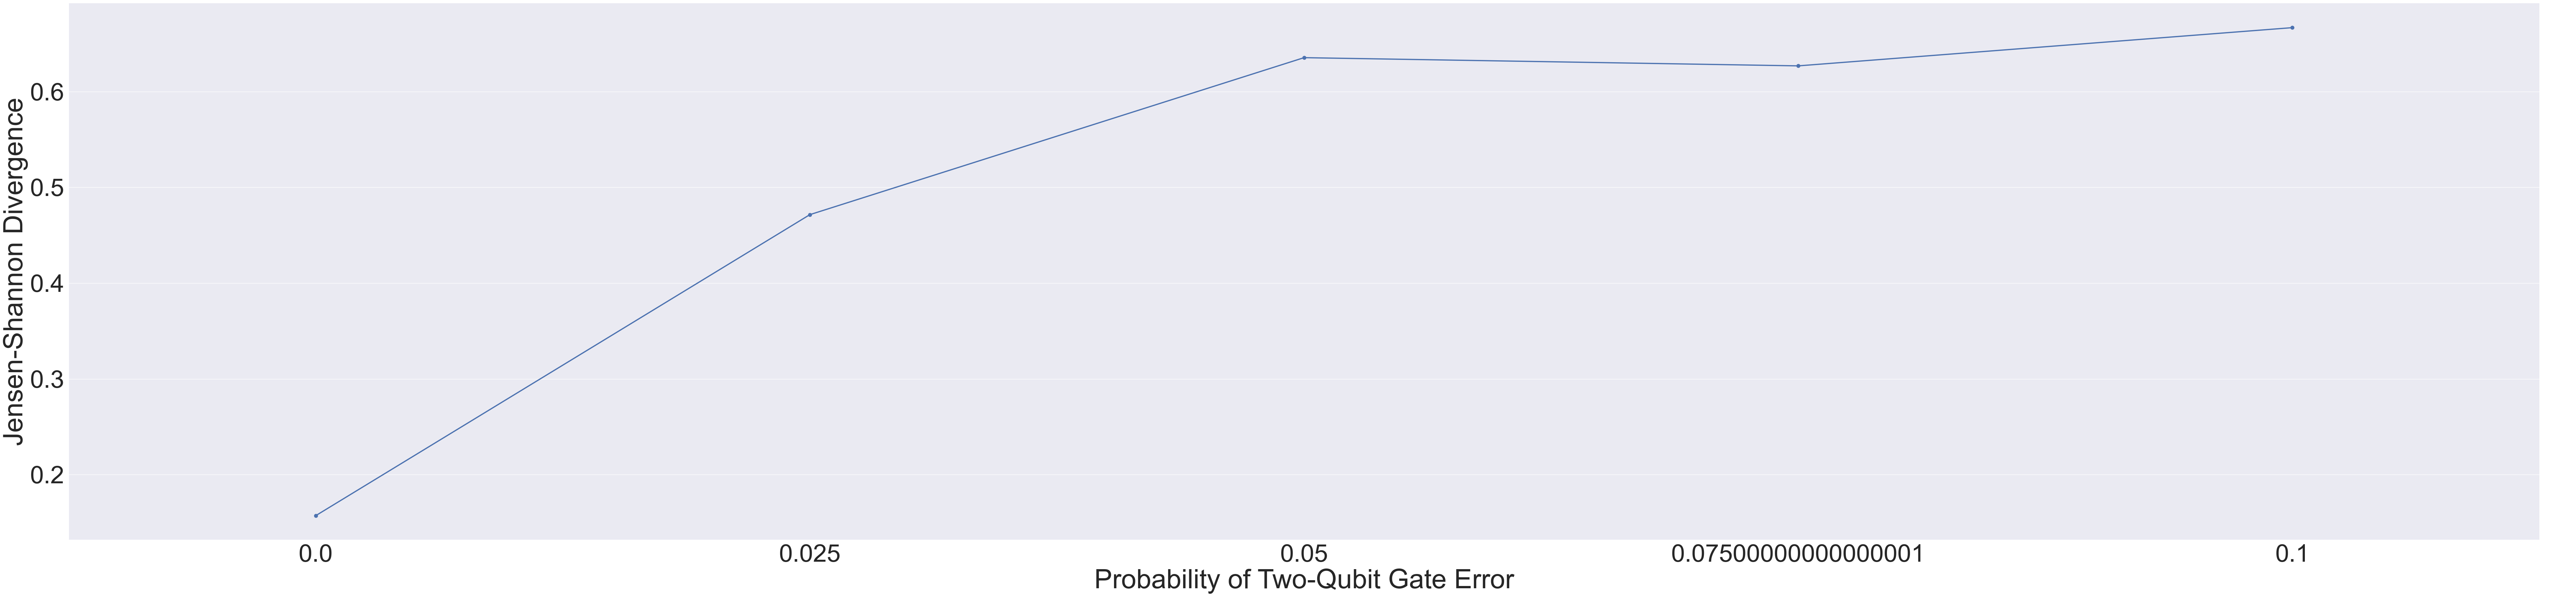

In [45]:
ax = sns.catplot(df, x="P2", y="JSD", kind="point", aspect=4, height=20)
ax.set_xlabels("Probability of Two-Qubit Gate Error")
ax.set_ylabels("Jensen-Shannon Divergence")

## Summary

H-Series provides emulators for end users to test, verify and optimize the jobs they will eventual submit to the H-Series devices. Two simulation modes exist for H-Series, `state-vector` and `stabilizer`. The simulation type will depend on the end users' use case. The noise model can be disabled for emulator targets with the suffix `E` or `Emulator`. Emulator targets with the suffix `LE` are noiseless. The noise model can be configured and customized by using the `error_params` kwarg on `qnexus.QuantinuumConfig`.

A use case showcases how increasing the `p2` value in the cloud emulator noise model leads to worse JSD estimates.

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>